# BNPL ML Model Development

**Objective**: Develop production-ready ML model for BNPL default risk prediction

**Performance Targets**:
- Beat current 3.5x risk discrimination baseline
- Achieve >40% precision on high-risk segment
- Maintain <100ms inference latency
- Production deployment ready

**Focus**: Primary target is `will_default` prediction (binary classification).

## Implementation Steps

### **Step 1: Algorithm Research & Selection** 
- Evaluate ML algorithms for BNPL risk assessment
- Consider inference latency requirements (<100ms)
- Assess interpretability for regulatory compliance
- Select candidate algorithms for testing

### **Step 2: Data Loading & Feature Engineering**
- Load engineered features using `BNPLFeatureEngineer` class
- Validate feature quality and distribution
- Prepare data for modeling

### **Step 3: Baseline Performance Establishment**
- Implement current underwriting baseline (3.5x discrimination)
- Train candidate models on engineered features
- Establish performance benchmarks

### **Step 4: Model Training & Evaluation**
- Cross-validation framework
- Business metrics: discrimination ratio, precision/recall
- Technical metrics: latency, model size, memory usage
- Feature importance analysis

### **Step 5: Production Readiness Assessment**
- Inference latency benchmarking
- Model serialization and deployment format
- Edge case handling and fallback strategies
- A/B testing framework preparation

### **Step 6: Model Selection & Recommendations**
- Compare algorithms across business and technical dimensions
- Select final model for production deployment
- Document trade-offs and deployment considerations
- Prepare ML engineering handoff

In [1]:
# Add project root to Python path for imports
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
print(f"Project root added to path: {project_root}")

Project root added to path: /Users/kevin/Documents/repos/flit-ml


In [2]:
# Environment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (ExtraTreesClassifier, HistGradientBoostingClassifier,
                            VotingClassifier, StackingClassifier, AdaBoostClassifier,
                            GradientBoostingClassifier, BaggingClassifier)
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


# Import models for training
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Import our custom feature engineering class
from flit_ml.features.bnpl_feature_engineering import BNPLFeatureEngineer

# Configuration
pd.set_option('display.max_columns', 50)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("ML development environment ready!")
print(f"Available ML libraries loaded successfully")

ML development environment ready!
Available ML libraries loaded successfully


## Step 1: Algorithm Research & Selection

### ML Algorithm Comparison for BNPL Risk Assessment

| Algorithm | Inference Speed | Interpretability | Performance | Memory Usage | Production Ready | Pros | Cons |
|-----------|----------------|------------------|-------------|--------------|------------------|------|------|
| **LogisticRegression** | Fastest (~1ms) | High (coefficients) | Good baseline | Minimal | Excellent | Fast inference, Interpretable, Stable, Low memory | Linear assumptions, May miss complex patterns |
| **RandomForestClassifier** | Fast (~5-10ms) | Medium (feature importance) | Strong for tabular | Moderate | Good | Handles non-linearity, Feature importance, Robust | Larger model size, Less interpretable |
| **XGBoost** | Fast (~10-20ms) | Medium (SHAP values) | Often best for tabular | Moderate | Good | High performance, Feature importance, Handles missing values | Hyperparameter tuning, Model complexity |
| **LightGBM** | Very Fast (~5ms) | Medium (SHAP values) | Excellent for tabular | Low | Excellent | Fast training/inference, Memory efficient, High performance | Can overfit small datasets, Less interpretable than linear |

### Selection Criteria for BNPL Production System

1. **Inference latency**: <100ms (preferably <20ms)
2. **Performance**: Beat 3.5x discrimination ratio
3. **Interpretability**: Regulatory compliance requirements
4. **Production stability**: Minimal maintenance overhead
5. **Memory efficiency**: Scalable serving architecture

### Recommended Starting Models

Based on BNPL constraints, we'll focus on all 4 models before considering more complex models.

## Step 2: Data Loading & Feature Engineering

Load engineered features using our production-ready `BNPLFeatureEngineer` class.

In [3]:
# Initialize feature engineer with clean output for development                                                                                                                                       
feature_engineer = BNPLFeatureEngineer(verbose=True)                                                                                                                                               
                                                                                                                                                                                                        
# Load and engineer features                                                                                                                                                                          
print("🚀 Loading and engineering features for model development...")                                                                                                                                 
df_features, feature_metadata = feature_engineer.engineer_features(                                                                                                                                   
    sample_size=1000,  # Sample size for development                                                                                                                                                  
    random_seed=42                                                                                                                                                                                    
)                                                                                                                                                                                                     
                                                                                                                                                                                                      
print(f"\n📊 Feature Engineering Complete:")                                                                                                                                                          
print(f"   Dataset shape: {df_features.shape}")                                                                                                                                                       
print(f"   Features available: {len(feature_metadata['all_features'])}")                                                                                                                              
print(f"   Target variable: {feature_metadata['target_variable']}")                                                                                                                                   
print(f"   Default rate: {df_features['will_default'].mean():.1%}")

🚀 Loading and engineering features for model development...
🚀 Starting complete BNPL feature engineering pipeline...
📥 Loading BNPL data from BigQuery...
   Sample size: 1,000 customers


E0000 00:00:1758819305.791071 28620280 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅ Data loaded: 84,389 transactions for 21,555 customers
   Default rate: 4.9%
   Memory usage: 92.0 MB

⏰ Step 2: Extracting temporal features...
✅ Temporal features extracted:
   transaction_id: 45973 unique values
   transaction_timestamp: 84190 unique values
   transaction_hour: 24 unique values
   transaction_day_of_week: 7 unique values
   transaction_month: 12 unique values
   transaction_day_of_month: 31 unique values
   week_of_month: 5 unique values
   is_weekend: 2 unique values
   is_month_end: 2 unique values
   is_holiday_season: 2 unique values
   is_business_hours: 2 unique values
   is_late_night: 2 unique values
   time_of_day: 4 unique values

🔧 Step 3: Encoding categorical features...
🔢 Applying ordinal encoding...
   customer_credit_score_range: ['good' 'excellent' 'fair' 'poor']
   customer_age_bracket: ['55+' '35-44' '18-24' '25-34' '45-54']
   customer_income_bracket: ['25k-50k' '<25k' '50k-75k' '75k-100k' '100k+']
   customer_verification_level: ['unverified' 'v

In [4]:
# Validate feature quality and distribution
print("🔍 Feature Quality Assessment:")
print(f"   Data shape: {df_features.shape}")
print(f"   Memory usage: {df_features.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"   Default rate: {df_features['will_default'].mean():.1%}")

# Check for any remaining issues
missing_values = df_features.isnull().sum().sum()
print(f"   Missing values: {missing_values}")

# Feature type summary
print(f"\n📋 Feature Types:")
for feature_type, features in feature_metadata.items():
    if isinstance(features, list) and feature_type.endswith('_features'):
        print(f"   {feature_type}: {len(features)} features")

# Display sample of features
print(f"\n📋 Sample of engineered features:")
display_cols = df_features.columns[:10].tolist()
if 'will_default' not in display_cols:
    display_cols.append('will_default')
    
df_features[display_cols].head()

🔍 Feature Quality Assessment:
   Data shape: (84389, 38)
   Memory usage: 28.2 MB
   Default rate: 4.9%
   Missing values: 0

📋 Feature Types:
   all_features: 38 features
   numeric_features: 37 features
   boolean_features: 0 features
   categorical_features: 1 features

📋 Sample of engineered features:


,amount,will_default,days_to_first_missed_payment,customer_tenure_days,device_is_trusted,risk_score,installment_count,payment_credit_limit,price_comparison_time,week_of_month
0,174.47,0,28,712.0,1,0.47,6.0,2500.0,171.0,1
1,396.65,0,28,712.0,1,0.44,6.0,2500.0,45.0,1
2,255.81,1,42,712.0,1,0.43,4.0,1500.0,219.0,1
3,102.17,0,28,712.0,1,0.46,6.0,5000.0,60.0,1
4,125.01,0,28,712.0,1,0.47,4.0,1500.0,216.0,1


In [5]:
# Prepare data for modeling
print("🔧 Preparing data for model training...")

# Separate features and target - exclude both target variables
exclude_cols = ['will_default', 'days_to_first_missed_payment']  # Remove both target variables, even though the 2nd one is secondary (for more enhanced models)
feature_cols = [col for col in df_features.columns if col not in exclude_cols]
numeric_features = ['amount', 'risk_score', 'payment_credit_limit', 'price_comparison_time', 'customer_tenure_days']
categorical_features = [col for col in feature_cols if col not in numeric_features]
primary_target_col = exclude_cols[0]  # 'will_default'
secondary_target_col = exclude_cols[1]  # 'days_to_first_missed_payment'

# For now, we will focus on the primary target
target_col = primary_target_col

X = df_features[feature_cols]
y = df_features[target_col]

print(f"   Features shape: {X.shape}")
print(f"   Target shape: {y.shape}")
print(f"   Target distribution: {y.value_counts().to_dict()}")
print(f"   Class balance: {y.mean():.1%} positive class")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n📊 Train-Test Split:")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")
print(f"   Train default rate: {y_train.mean():.1%}")
print(f"   Test default rate: {y_test.mean():.1%}")

🔧 Preparing data for model training...
   Features shape: (84389, 36)
   Target shape: (84389,)
   Target distribution: {0: 80277, 1: 4112}
   Class balance: 4.9% positive class

📊 Train-Test Split:
   Training set: (67511, 36)
   Test set: (16878, 36)
   Train default rate: 4.9%
   Test default rate: 4.9%


In [6]:
# Feature scaling for algorithms that need it
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


 # Create preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),      # Scale numeric features
    ('cat', 'passthrough', categorical_features)      # Leave categorical unchanged
])

X_train_processed = preprocessor.fit_transform(X_train)  # Fit AND transform train
X_test_processed = preprocessor.transform(X_test)        # Only transform test (using train's fit) --> Avoid inconsistent scaling train vs test


print(f"\n✅ Data preparation complete")
print(f"   Ready for model training and evaluation")


✅ Data preparation complete
   Ready for model training and evaluation


## Step 3: Baseline Performance Establishment

Implement current underwriting baseline and train candidate models.

In [7]:
# Current underwriting baseline analysis
print("📊 Current Underwriting Baseline Analysis")
print("=" * 45)

# Analyze current risk_score and risk_level performance
if 'risk_score' in df_features.columns and 'risk_level_encoded' in df_features.columns:
    
    # Risk level performance
    risk_performance = df_features.groupby('risk_level_encoded')['will_default'].agg(['count', 'mean']).round(3)
    risk_performance.columns = ['transaction_count', 'default_rate']
    
    print(f"\n🎯 Current Risk Level Performance:")
    risk_level_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}
    for idx, row in risk_performance.iterrows():
        level_name = risk_level_mapping.get(idx, f'Level_{idx}')
        print(f"   {level_name} Risk: {row['default_rate']:.1%} default rate ({row['transaction_count']:,} transactions)")
    
    # Calculate discrimination ratio
    high_risk_rate = risk_performance.loc[2, 'default_rate']  # High risk (encoded as 2)
    low_risk_rate = risk_performance.loc[0, 'default_rate']   # Low risk (encoded as 0)
    current_discrimination = high_risk_rate / low_risk_rate if low_risk_rate > 0 else 0
    
    print(f"\n📈 Current System Discrimination:")
    print(f"   High risk default rate: {high_risk_rate:.1%}")
    print(f"   Low risk default rate: {low_risk_rate:.1%}")
    print(f"   Discrimination ratio: {current_discrimination:.1f}x")
    print(f"   Target to beat: >{current_discrimination:.1f}x")
    
    # Risk score distribution analysis
    print(f"\n📊 Risk Score Distribution:")
    risk_score_stats = df_features['risk_score'].describe()
    print(f"   Range: {risk_score_stats['min']:.2f} - {risk_score_stats['max']:.2f}")
    print(f"   Mean: {risk_score_stats['mean']:.2f}")
    print(f"   Std: {risk_score_stats['std']:.2f}")
    
else:
    print("⚠️  Risk score/level features not available in dataset")
    current_discrimination = 3.5  # Use known baseline from context
    print(f"   Using known baseline discrimination ratio: {current_discrimination}x")

# Set performance targets
target_discrimination = max(current_discrimination * 1.1, 4.0)  # At least 10% improvement or 4.0x
target_precision = 0.40  # 40% precision on high-risk segment

print(f"\n🎯 Performance Targets for ML Models:")
print(f"   Discrimination ratio: >{target_discrimination:.1f}x")
print(f"   High-risk precision: >{target_precision:.0%}")
print(f"   Inference latency: <100ms")
print(f"   Model size: <50MB (for fast loading)")

📊 Current Underwriting Baseline Analysis

🎯 Current Risk Level Performance:
   Low Risk: 3.2% default rate (27,899.0 transactions)
   Medium Risk: 5.6% default rate (55,475.0 transactions)
   High Risk: 9.0% default rate (1,015.0 transactions)

📈 Current System Discrimination:
   High risk default rate: 9.0%
   Low risk default rate: 3.2%
   Discrimination ratio: 2.8x
   Target to beat: >2.8x

📊 Risk Score Distribution:
   Range: 0.11 - 0.76
   Mean: 0.35
   Std: 0.11

🎯 Performance Targets for ML Models:
   Discrimination ratio: >4.0x
   High-risk precision: >40%
   Inference latency: <100ms
   Model size: <50MB (for fast loading)


## Step 4: Model Training & Cross-Validation

Train candidate models with proper preprocessing and evaluate using cross-validation.

In [8]:
# Initialize models for comparison
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
    'LightGBM': LGBMClassifier(random_state=42, verbosity=-1),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

print(f"🤖 Models initialized: {list(models.keys())}")

# Cross-validation setup
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(f"📊 Cross-validation: {cv_folds.n_splits}-fold stratified")

🤖 Models initialized: ['LogisticRegression', 'RandomForest', 'LightGBM', 'XGBoost']
📊 Cross-validation: 5-fold stratified


In [9]:
cv_results = {}

print("🚀 Starting model training and cross-validation...")
print("=" * 60)

for model_name, model in models.items():
    print(f"\n🔧 Training {model_name}...")

    # Use appropriate data (scaled for LR, unscaled for tree-based)
    if model_name == 'LogisticRegression':
        X_train_model = X_train_processed
        X_test_model = X_test_processed
    else:
        # Tree-based models don't need scaling
        X_train_model = X_train.values
        X_test_model = X_test.values

    # Cross-validation
    start_time = time.time()
    cv_scores = cross_val_score(model, X_train_model, y_train, cv=cv_folds, scoring='roc_auc')
    cv_time = time.time() - start_time

    # Train on full training set
    start_time = time.time()
    model.fit(X_train_model, y_train)
    train_time = time.time() - start_time

    # Store results
    cv_results[model_name] = {
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_time': cv_time,
        'train_time': train_time,
        'model': model
    }

    print(f"   CV ROC-AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"   CV Time: {cv_time:.2f}s, Train Time: {train_time:.2f}s")

print(f"\n✅ Model training complete!")

🚀 Starting model training and cross-validation...

🔧 Training LogisticRegression...


   CV ROC-AUC: 0.589 ± 0.004
   CV Time: 19.18s, Train Time: 4.34s

🔧 Training RandomForest...
   CV ROC-AUC: 0.542 ± 0.008
   CV Time: 37.58s, Train Time: 9.80s

🔧 Training LightGBM...
   CV ROC-AUC: 0.567 ± 0.003
   CV Time: 23.30s, Train Time: 5.22s

🔧 Training XGBoost...
   CV ROC-AUC: 0.537 ± 0.007
   CV Time: 14.24s, Train Time: 3.17s

✅ Model training complete!


Initial model training gives AUC of ~0.5, showing poor performance across models. Let's investigate this:

In [10]:
X_train_processed

array([[-0.62075524, -0.25990637,  0.25203346, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.3445796 , -0.25990637, -0.37395643, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.15973998,  0.02209561, -0.68695137, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.83116173,  0.21009693, -0.37395643, ...,  0.        ,
         0.        ,  0.        ],
       [-0.62065384, -0.16590571,  1.81700819, ...,  0.        ,
         1.        ,  0.        ],
       [-0.75125796, -1.19991297, -0.37395643, ...,  1.        ,
         0.        ,  0.        ]])

🔍 Feature-Target Correlations:
risk_score                             0.076312
risk_level_encoded                     0.056039
customer_credit_score_range_encoded   -0.049174
customer_income_bracket_encoded       -0.037121
customer_verification_level_encoded   -0.036637
risk_scenario_low_risk_purchase       -0.013947
risk_scenario_high_risk_behavior       0.012503
purchase_context_rushed                0.012503
product_risk_category_encoded          0.012235
purchase_context_normal               -0.009471
Name: will_default, dtype: float64

Features with |correlation| > 0.1: 0
⚠️ No features have strong correlation with target!


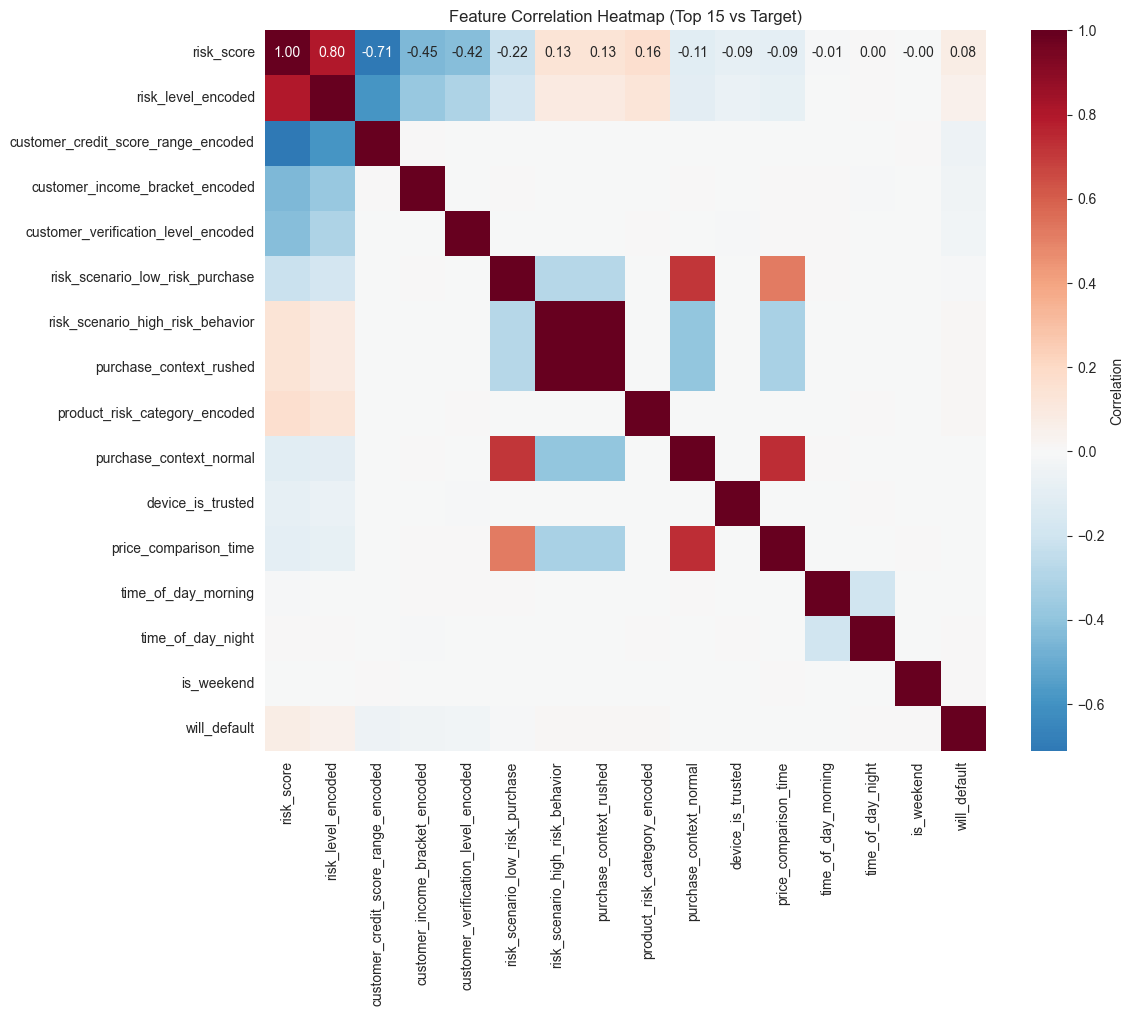


📊 Data Sanity Checks:
Target distribution: {0: 80277, 1: 4112}
Features shape: (84389, 36)
Any missing values in X: 0
Feature columns: ['amount', 'customer_tenure_days', 'device_is_trusted', 'risk_score', 'installment_count']...


In [11]:
# Check correlations with target variable
print("🔍 Feature-Target Correlations:")
target_corrs = df_features.corr()['will_default'].drop(['will_default','days_to_first_missed_payment']).sort_values(key=abs, ascending=False)
print(target_corrs.head(10))

# Check if we have any strong correlations
strong_corrs = target_corrs[abs(target_corrs) > 0.1]
print(f"\nFeatures with |correlation| > 0.1: {len(strong_corrs)}")
if len(strong_corrs) > 0:
    print(strong_corrs)
else:
    print("⚠️ No features have strong correlation with target!")

# Correlation heatmap
plt.figure(figsize=(12, 10))
# Focus on features most correlated with target
top_features = target_corrs.head(15).index.tolist() + ['will_default']
corr_matrix = df_features[top_features].corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', square=True, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Heatmap (Top 15 vs Target)')
plt.tight_layout()
plt.show()

# Quick sanity checks
print(f"\n📊 Data Sanity Checks:")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"Features shape: {X.shape}")
print(f"Any missing values in X: {X.isnull().sum().sum()}")
print(f"Feature columns: {list(X.columns[:5])}...")

In [12]:
print("X_train columns:", list(X_train.columns))
print("X_train shape:", X_train.shape)


# Correlations for features actually used in training
train_data_with_target = pd.concat([X_train, y_train], axis=1)
actual_corrs = train_data_with_target.corr()['will_default'].drop('will_default').sort_values(key=abs, ascending=False)
print("Actual training feature correlations:")
print(actual_corrs.head(10))


print("Are we using X_train for tree models?", type(X_train))
print("Are we using X_train_processed for LogReg?", type(X_train_processed))

X_train columns: ['amount', 'customer_tenure_days', 'device_is_trusted', 'risk_score', 'installment_count', 'payment_credit_limit', 'price_comparison_time', 'week_of_month', 'is_weekend', 'is_month_end', 'is_holiday_season', 'is_business_hours', 'is_late_night', 'customer_credit_score_range_encoded', 'customer_age_bracket_encoded', 'customer_income_bracket_encoded', 'customer_verification_level_encoded', 'product_risk_category_encoded', 'risk_level_encoded', 'device_type_mobile', 'device_type_tablet', 'payment_provider_afterpay', 'payment_provider_klarna', 'payment_provider_sezzle', 'product_category_clothing', 'product_category_electronics', 'product_category_home', 'product_category_sports', 'purchase_context_normal', 'purchase_context_rushed', 'risk_scenario_high_risk_behavior', 'risk_scenario_impulse_purchase', 'risk_scenario_low_risk_purchase', 'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night']
X_train shape: (67511, 36)


Actual training feature correlations:
risk_score                             0.073647
risk_level_encoded                     0.054906
customer_credit_score_range_encoded   -0.046650
customer_income_bracket_encoded       -0.037941
customer_verification_level_encoded   -0.035395
product_risk_category_encoded          0.012780
risk_scenario_low_risk_purchase       -0.012470
risk_scenario_high_risk_behavior       0.009637
purchase_context_rushed                0.009637
time_of_day_night                      0.008336
Name: will_default, dtype: float64
Are we using X_train for tree models? <class 'pandas.core.frame.DataFrame'>
Are we using X_train_processed for LogReg? <class 'numpy.ndarray'>


In [13]:
train_data_with_target = pd.concat([X_train, y_train], axis=1)
actual_corrs = train_data_with_target.corr()['will_default'].drop('will_default').sort_values(key=abs, ascending=False)

print("🔍 ACTUAL Training Feature Correlations:")
print(actual_corrs.head(10))

print(f"\nFeatures with |correlation| > 0.05:")
strong_corrs = actual_corrs[abs(actual_corrs) > 0.05]
print(strong_corrs)

print(f"\nX_train columns: {list(X_train.columns)}")
print(f"X_train shape: {X_train.shape}")

🔍 ACTUAL Training Feature Correlations:
risk_score                             0.073647
risk_level_encoded                     0.054906
customer_credit_score_range_encoded   -0.046650
customer_income_bracket_encoded       -0.037941
customer_verification_level_encoded   -0.035395
product_risk_category_encoded          0.012780
risk_scenario_low_risk_purchase       -0.012470
risk_scenario_high_risk_behavior       0.009637
purchase_context_rushed                0.009637
time_of_day_night                      0.008336
Name: will_default, dtype: float64

Features with |correlation| > 0.05:
risk_score            0.073647
risk_level_encoded    0.054906
Name: will_default, dtype: float64

X_train columns: ['amount', 'customer_tenure_days', 'device_is_trusted', 'risk_score', 'installment_count', 'payment_credit_limit', 'price_comparison_time', 'week_of_month', 'is_weekend', 'is_month_end', 'is_holiday_season', 'is_business_hours', 'is_late_night', 'customer_credit_score_range_encoded', 'custome

In [14]:
# Test if current risk_level shows expected discrimination
print("Risk level performance check:")
risk_perf = df_features.groupby('risk_level_encoded')['will_default'].mean()
print(risk_perf)

Risk level performance check:
risk_level_encoded
0.0    0.032295
1.0    0.056242
2.0    0.089655
Name: will_default, dtype: float64


In [15]:
print("Features removed during cleaning:")
removed_features = feature_metadata.get('features_removed', [])
for feature in removed_features:
    print(f"  - {feature}")

print(f"\nTotal removed: {len(removed_features)}")

Features removed during cleaning:
  - transaction_month
  - transaction_id
  - transaction_hour
  - product_risk_category
  - customer_income_bracket
  - transaction_timestamp
  - device_type
  - risk_level
  - purchase_context
  - payment_type
  - transaction_day_of_month
  - time_of_day
  - customer_age_bracket
  - customer_verification_level
  - product_category
  - customer_credit_score_range
  - product_price
  - payment_provider
  - risk_scenario
  - customer_id
  - customer_state
  - transaction_day_of_week
  - time_on_site_seconds

Total removed: 23


The first 4 models gave a performance as poor as random, and yet there seems to be no obvious reason apart from the poor correlation btn features and the predicted. So this is mostly a data quality issue --  our data is not predictive or it's just plain unrealistic (again, feedback for Simtom). Question is, though, it is possible to still get some predictive power from features that have such low correlation levels to our target variable? To determine this, we will brute-force our eval of models and just throw many models at the problem to see which one likely gives something reasonable.

In [16]:
# Complete model portfolio - All Tiers
models = {
    # Original models
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
    'LightGBM': LGBMClassifier(random_state=42, verbosity=-1),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),

    # Tier 1: Must Try
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42, n_estimators=100),
    #'ComplementNB': ComplementNB(),

    # Tier 2: High Value
    'Ridge': RidgeClassifier(random_state=42),
    'ElasticNet': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga',
                                    random_state=42, max_iter=1000),
    #'SVM_Linear': SVC(kernel='linear', probability=True, random_state=42),
    #'MLPClassifier': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500),

    # Tier 3: Experimental  
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'KNN_Weighted': KNeighborsClassifier(n_neighbors=10, weights='distance'),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'BernoulliNB': BernoulliNB(),
    'SGDClassifier': SGDClassifier(random_state=42, loss='log_loss', max_iter=1000),
    'BaggingClassifier': BaggingClassifier(random_state=42),
    'SVM_RBF': SVC(kernel='rbf', probability=True, random_state=42),
}

print(f"🤖 Complete model portfolio: {len(models)} algorithms")
print("Tier breakdown:")
print("  Original: LogisticRegression, RandomForest, LightGBM, XGBoost")
print("  Tier 1: HistGradientBoosting, ExtraTrees, ComplementNB")
print("  Tier 2: Ridge, ElasticNet, SVM_Linear, MLPClassifier")
print("  Tier 3: KNN variants, AdaBoost, GradientBoosting, BernoulliNB, SGD, Bagging, SVM_RBF")

🤖 Complete model portfolio: 16 algorithms
Tier breakdown:
  Original: LogisticRegression, RandomForest, LightGBM, XGBoost
  Tier 1: HistGradientBoosting, ExtraTrees, ComplementNB
  Tier 2: Ridge, ElasticNet, SVM_Linear, MLPClassifier
  Tier 3: KNN variants, AdaBoost, GradientBoosting, BernoulliNB, SGD, Bagging, SVM_RBF


In [17]:
# Enhanced training with proper error handling and model-specific logic
cv_results = {}

# Model-specific configurations
model_configs = {
    'SVM_RBF': {'max_samples': 10000},  # Subsample for speed
    'SVM_Linear': {'max_samples': 20000},
    'KNN': {'max_samples': 15000},
    'KNN_Weighted': {'max_samples': 15000},
}

print("🚀 Starting robust model training and evaluation...")
print(f"Training {len(models)} models on {X_train.shape[0]:,} samples")
print("=" * 70)

for model_name, model in models.items():
    print(f"\n🔧 Training {model_name}...")

    # Determine preprocessing needs
    scaling_models = ['LogisticRegression', 'ElasticNet', 'SVM_Linear', 'SVM_RBF',
                    'MLPClassifier', 'KNN', 'KNN_Weighted', 'SGDClassifier','Ridge']

    # Prepare data
    if model_name in scaling_models:
        X_train_model = X_train_processed
        X_test_model = X_test_processed
        data_type = "scaled"
    else:
        X_train_model = X_train
        X_test_model = X_test
        data_type = "unscaled"

    # Apply model-specific sampling if needed
    if model_name in model_configs:
        max_samples = model_configs[model_name].get('max_samples')
        if max_samples and len(X_train_model) > max_samples:
            from sklearn.model_selection import train_test_split
            X_sample, _, y_sample, _ = train_test_split(
                X_train_model, y_train, train_size=max_samples,
                stratify=y_train, random_state=42
            )
            X_train_model, y_train_model = X_sample, y_sample
            print(f"   Using subsample: {len(X_train_model):,} samples")
        else:
            y_train_model = y_train
    else:
        y_train_model = y_train

    try:
        # Cross-validation with timeout
        start_time = time.time()
        cv_scores = cross_val_score(model, X_train_model, y_train_model,
                                    cv=cv_folds, scoring='roc_auc', n_jobs=1)
        cv_time = time.time() - start_time

        # Skip if CV takes too long
        if cv_time > 300:  # 5 minutes timeout
            print(f"   ⏰ Timeout: CV took {cv_time:.1f}s, skipping")
            continue

        # Train on full training set
        start_time = time.time()
        model.fit(X_train_model, y_train_model)
        train_time = time.time() - start_time

        # Test predictions with proper handling
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test_model)[:, 1]
        elif hasattr(model, 'decision_function'):
            # For Ridge, SVM without probability
            y_pred_proba = model.decision_function(X_test_model)
        else:
            print(f"   ⚠️ No probability/decision function available")
            continue

        test_auc = roc_auc_score(y_test, y_pred_proba)

        # Store results
        cv_results[model_name] = {
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_auc': test_auc,
            'cv_time': cv_time,
            'train_time': train_time,
            'model': model,
            'data_type': data_type,
            'status': 'success',
            'samples_used': len(X_train_model)
        }

        print(f"   CV ROC-AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        print(f"   Test ROC-AUC: {test_auc:.3f}")
        print(f"   Times: CV={cv_time:.1f}s, Train={train_time:.2f}s")

    except Exception as e:
        print(f"   ❌ Failed: {str(e)[:100]}")
        cv_results[model_name] = {'status': 'failed', 'error': str(e)}

print(f"\n✅ Robust training complete!")

🚀 Starting robust model training and evaluation...
Training 16 models on 67,511 samples

🔧 Training LogisticRegression...
   CV ROC-AUC: 0.589 ± 0.004
   Test ROC-AUC: 0.615
   Times: CV=19.3s, Train=3.84s

🔧 Training RandomForest...
   CV ROC-AUC: 0.542 ± 0.008
   Test ROC-AUC: 0.573
   Times: CV=57.8s, Train=18.27s

🔧 Training LightGBM...
   CV ROC-AUC: 0.567 ± 0.003
   Test ROC-AUC: 0.599
   Times: CV=106.8s, Train=14.65s

🔧 Training XGBoost...
   CV ROC-AUC: 0.537 ± 0.007
   Test ROC-AUC: 0.559
   Times: CV=66.6s, Train=11.39s

🔧 Training HistGradientBoosting...
   CV ROC-AUC: 0.581 ± 0.006
   Test ROC-AUC: 0.607
   Times: CV=131.6s, Train=35.55s

🔧 Training ExtraTrees...
   CV ROC-AUC: 0.538 ± 0.010
   Test ROC-AUC: 0.567
   Times: CV=62.4s, Train=14.28s

🔧 Training Ridge...
   CV ROC-AUC: 0.589 ± 0.005
   Test ROC-AUC: 0.616
   Times: CV=1.6s, Train=0.53s

🔧 Training ElasticNet...
   CV ROC-AUC: 0.589 ± 0.004
   Test ROC-AUC: 0.615
   Times: CV=67.0s, Train=16.34s

🔧 Training KNN

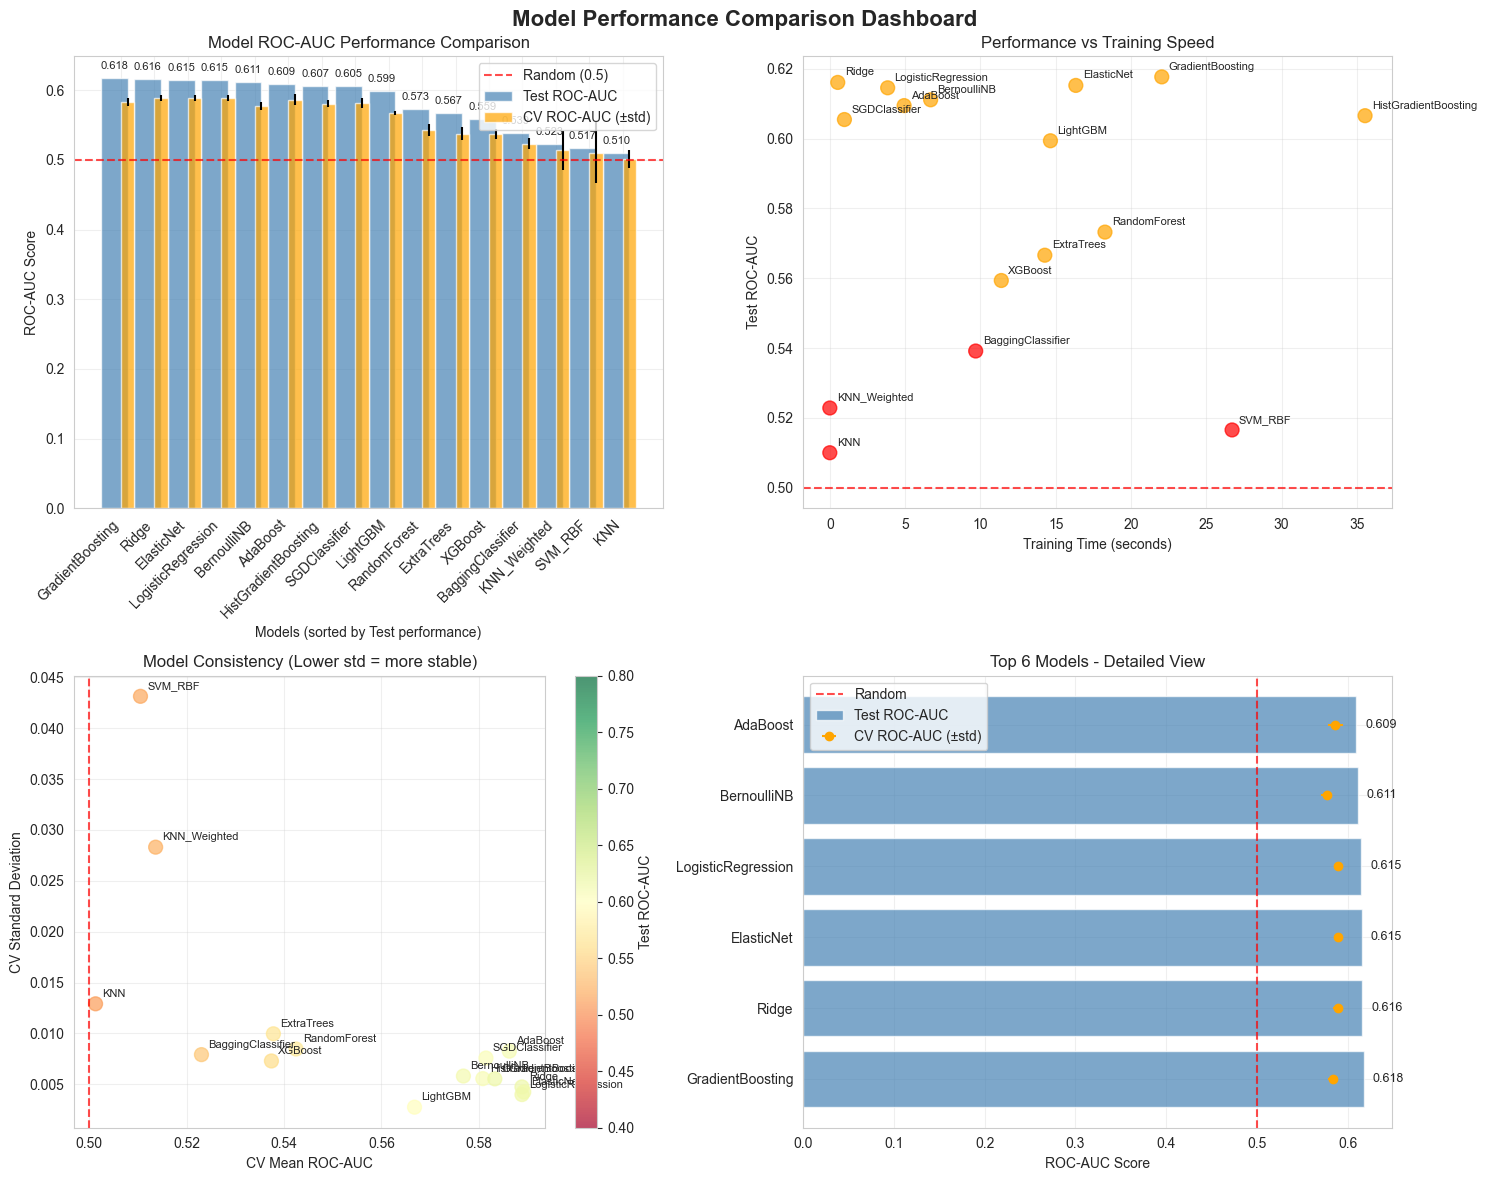


📊 Performance Summary Table
Model                Test AUC   CV Mean    CV Std     Train Time  
--------------------------------------------------------------------------------
GradientBoosting     0.618      0.583      0.006      22.05       s
Ridge                0.616      0.589      0.005      0.53        s
ElasticNet           0.615      0.589      0.004      16.34       s
LogisticRegression   0.615      0.589      0.004      3.84        s
BernoulliNB          0.611      0.577      0.006      6.70        s
AdaBoost             0.609      0.586      0.008      4.94        s
HistGradientBoosting 0.607      0.581      0.006      35.55       s
SGDClassifier        0.605      0.582      0.008      0.97        s
LightGBM             0.599      0.567      0.003      14.65       s
RandomForest         0.573      0.542      0.008      18.27       s
ExtraTrees           0.567      0.538      0.010      14.28       s
XGBoost              0.559      0.537      0.007      11.39       s
Bagging

In [18]:
# Extract successful results
successful_models = {k: v for k, v in cv_results.items() if v.get('status') == 'success'}

if len(successful_models) == 0:
    print("❌ No successful models to plot!")
else:
    # Create subplots for multiple comparisons
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance Comparison Dashboard', fontsize=16, fontweight='bold')

    # 1. ROC-AUC Performance Comparison
    ax1 = axes[0, 0]
    model_names = list(successful_models.keys())
    test_aucs = [successful_models[name]['test_auc'] for name in model_names]
    cv_means = [successful_models[name]['cv_mean'] for name in model_names]
    cv_stds = [successful_models[name]['cv_std'] for name in model_names]

    # Sort by test performance
    sorted_indices = sorted(range(len(test_aucs)), key=lambda i: test_aucs[i], reverse=True)
    model_names_sorted = [model_names[i] for i in sorted_indices]
    test_aucs_sorted = [test_aucs[i] for i in sorted_indices]
    cv_means_sorted = [cv_means[i] for i in sorted_indices]
    cv_stds_sorted = [cv_stds[i] for i in sorted_indices]

    x_pos = range(len(model_names_sorted))
    bars1 = ax1.bar(x_pos, test_aucs_sorted, alpha=0.7, label='Test ROC-AUC', color='steelblue')
    bars2 = ax1.bar([x + 0.4 for x in x_pos], cv_means_sorted, alpha=0.7,
                    yerr=cv_stds_sorted, label='CV ROC-AUC (±std)', color='orange', width=0.4)

    ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random (0.5)')
    ax1.set_xlabel('Models (sorted by Test performance)')
    ax1.set_ylabel('ROC-AUC Score')
    ax1.set_title('Model ROC-AUC Performance Comparison')
    ax1.set_xticks([x + 0.2 for x in x_pos])
    ax1.set_xticklabels(model_names_sorted, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        ax1.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01,
                f'{test_aucs_sorted[i]:.3f}', ha='center', va='bottom', fontsize=8)

    # 2. Training Time vs Performance
    ax2 = axes[0, 1]
    train_times = [successful_models[name]['train_time'] for name in model_names]
    colors = ['red' if auc < 0.55 else 'orange' if auc < 0.65 else 'green'
            for auc in test_aucs]

    scatter = ax2.scatter(train_times, test_aucs, c=colors, s=100, alpha=0.7)
    for i, name in enumerate(model_names):
        ax2.annotate(name, (train_times[i], test_aucs[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
    ax2.set_xlabel('Training Time (seconds)')
    ax2.set_ylabel('Test ROC-AUC')
    ax2.set_title('Performance vs Training Speed')
    ax2.grid(True, alpha=0.3)

    # 3. Cross-Validation Consistency (CV mean vs std)
    ax3 = axes[1, 0]
    cv_consistency = ax3.scatter(cv_means, cv_stds, s=100, alpha=0.7, c=test_aucs,
                                cmap='RdYlGn', vmin=0.4, vmax=0.8)
    for i, name in enumerate(model_names):
        ax3.annotate(name, (cv_means[i], cv_stds[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax3.axvline(x=0.5, color='red', linestyle='--', alpha=0.7)
    ax3.set_xlabel('CV Mean ROC-AUC')
    ax3.set_ylabel('CV Standard Deviation')
    ax3.set_title('Model Consistency (Lower std = more stable)')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(cv_consistency, ax=ax3, label='Test ROC-AUC')

    # 4. Top Models Detailed Comparison
    ax4 = axes[1, 1]
    # Show top 6 models
    top_n = min(6, len(model_names_sorted))
    top_models = model_names_sorted[:top_n]
    top_test_aucs = test_aucs_sorted[:top_n]
    top_cv_means = cv_means_sorted[:top_n]
    top_cv_stds = cv_stds_sorted[:top_n]

    x_pos_top = range(top_n)
    ax4.barh(x_pos_top, top_test_aucs, alpha=0.7, color='steelblue', label='Test ROC-AUC')
    ax4.errorbar(top_cv_means, x_pos_top, xerr=top_cv_stds, fmt='o',
                color='orange', label='CV ROC-AUC (±std)')

    ax4.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Random')
    ax4.set_yticks(x_pos_top)
    ax4.set_yticklabels(top_models)
    ax4.set_xlabel('ROC-AUC Score')
    ax4.set_title(f'Top {top_n} Models - Detailed View')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Add value labels
    for i, auc in enumerate(top_test_aucs):
        ax4.text(auc + 0.01, i, f'{auc:.3f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# Summary statistics table
print(f"\n📊 Performance Summary Table")
print("="*80)
print(f"{'Model':<20} {'Test AUC':<10} {'CV Mean':<10} {'CV Std':<10} {'Train Time':<12}")
print("-"*80)
for name in model_names_sorted:
    results = successful_models[name]
    print(f"{name:<20} {results['test_auc']:<10.3f} {results['cv_mean']:<10.3f} "
        f"{results['cv_std']:<10.3f} {results['train_time']:<12.2f}s")

# Quick insights
best_model = model_names_sorted[0]
print(f"\n🏆 Best performing model: {best_model} (AUC: {successful_models[best_model]['test_auc']:.3f})")

breakthrough_models = [name for name, results in successful_models.items()
                    if results['test_auc'] > 0.55]
if breakthrough_models:
    print(f"🚀 Models breaking through 0.55 barrier: {len(breakthrough_models)}")
    for name in breakthrough_models:
        print(f"   - {name}: {successful_models[name]['test_auc']:.3f}")
else:
    print("⚠️  No models achieved AUC > 0.55")

In [19]:
# 1. Select Top Models for Tuning
# Extract top 5 models by performance with speed considerations
top_models_for_tuning = []
for name in model_names_sorted[:8]:  # Consider top 8
    results = successful_models[name]
    # Balance: AUC > 0.6 AND training time < 5s (adjustable threshold)
    if results['test_auc'] >= 0.59 and results['train_time'] < 15.0:
        top_models_for_tuning.append((name, results))

print("🎯 Selected models for hyperparameter tuning:")
for name, results in top_models_for_tuning[:10]:
    print(f"  {name}: AUC={results['test_auc']:.3f}, Time={results['train_time']:.2f}s")

🎯 Selected models for hyperparameter tuning:
  Ridge: AUC=0.616, Time=0.53s
  LogisticRegression: AUC=0.615, Time=3.84s
  BernoulliNB: AUC=0.611, Time=6.70s
  AdaBoost: AUC=0.609, Time=4.94s
  SGDClassifier: AUC=0.605, Time=0.97s


In [21]:
# Hyperparameter grids focusing on speed AND performance
param_grids = {
    'GradientBoosting': {
        'n_estimators': [50, 100],  # Reduce from default for speed
        'learning_rate': [0.1, 0.15, 0.2],  # Higher LR = fewer iterations
        'max_depth': [3, 5],  # Shallower trees = faster
        'subsample': [0.8, 1.0],  # Subsampling for speed
    },

    'Ridge': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr'],
        'fit_intercept': [True, False]
    },

    'ElasticNet': {
        'C': [0.1, 1.0, 10.0, 100.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'max_iter': [500, 1000],  # Reduce iterations for speed
        'tol': [1e-3, 1e-4]  # Relaxed tolerance for speed
    },

    'LogisticRegression': {
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000],
        'tol': [1e-3, 1e-4]
    },

    'BernoulliNB': {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True, False],
        'binarize': [0.0, 0.1, 0.5]
    },

    'AdaBoost': {
        'n_estimators': [50, 100, 200],  # Test if more helps
        'learning_rate': [0.5, 1.0, 1.5],
        'algorithm': ['SAMME', 'SAMME.R']
    },

    'HistGradientBoosting': {
        'learning_rate': [0.05, 0.1, 0.15, 0.2],
        'max_iter': [100, 200, 300],
        'max_depth': [3, 6, 10, None],
        'min_samples_leaf': [5, 10, 20]
    },

    'SGDClassifier': {
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'optimal', 'invscaling'],
        'eta0': [0.01, 0.1, 1.0],
        'max_iter': [500, 1000],
        'tol': [1e-3, 1e-4]
    },

    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'num_leaves': [20, 31, 50],
        'learning_rate': [0.05, 0.1, 0.15],
        'min_child_samples': [10, 20],
        'subsample': [0.8, 1.0]
    }
}

print("🎯 Tuning all 9 models with AUC ≥ 0.6")
print("Focus areas:")
print("  Speed optimization: GradientBoosting, ElasticNet")
print("  Performance boost: Ridge, LogisticRegression, BernoulliNB, HistGB, SGD")
print("  Push over threshold: LightGBM (0.599 → 0.6+)")
print("  Balance optimization: AdaBoost")

🎯 Tuning all 9 models with AUC ≥ 0.6
Focus areas:
  Speed optimization: GradientBoosting, ElasticNet
  Performance boost: Ridge, LogisticRegression, BernoulliNB, HistGB, SGD
  Push over threshold: LightGBM (0.599 → 0.6+)
  Balance optimization: AdaBoost


In [23]:
# 3. Efficient Tuning Strategy

tuned_models = {}

print("🔧 Starting hyperparameter tuning for top models...")
print("="*60)

for model_name, _ in top_models_for_tuning:
    if model_name not in param_grids:
        continue

    print(f"\n🎯 Tuning {model_name}...")

    # Get base model and data
    base_model = models[model_name]
    if model_name in scaling_models:
        X_tune, y_tune = X_train_processed, y_train
    else:
        X_tune, y_tune = X_train.values, y_train

    try:
        # Use RandomizedSearchCV for speed
        search = RandomizedSearchCV(
            base_model,
            param_grids[model_name],
            n_iter=25,  # Increased for better coverage
            cv=3,       # 3-fold for speed
            scoring='roc_auc',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )

        start_time = time.time()
        search.fit(X_tune, y_tune)
        tune_time = time.time() - start_time

        # Test best model with proper probability handling
        best_model = search.best_estimator_
        if model_name in scaling_models:
            X_test_model = X_test_processed
        else:
            X_test_model = X_test.values

        # Handle different model prediction methods
        if hasattr(best_model, 'predict_proba'):
            y_pred_proba = best_model.predict_proba(X_test_model)[:, 1]
        elif hasattr(best_model, 'decision_function'):
            # For Ridge, SVM without probability
            y_pred_proba = best_model.decision_function(X_test_model)
        else:
            print(f"   ⚠️  No probability method available for {model_name}")
            continue

        tuned_auc = roc_auc_score(y_test, y_pred_proba)
        baseline_auc = successful_models[model_name]['test_auc']
        improvement = tuned_auc - baseline_auc

        tuned_models[model_name] = {
            'model': best_model,
            'best_params': search.best_params_,
            'best_cv_score': search.best_score_,
            'test_auc': tuned_auc,
            'baseline_auc': baseline_auc,
            'improvement': improvement,
            'tune_time': tune_time,
            'status': 'success'
        }

        print(f"   Best params: {search.best_params_}")
        print(f"   Baseline AUC: {baseline_auc:.3f} → Tuned AUC: {tuned_auc:.3f}")
        print(f"   Improvement: {improvement:+.3f} ({tune_time:.1f}s tuning)")

    except Exception as e:
        print(f"   ❌ Tuning failed: {str(e)[:100]}")
        tuned_models[model_name] = {'status': 'failed', 'error': str(e)}

🔧 Starting hyperparameter tuning for top models...

🎯 Tuning Ridge...
   Best params: {'solver': 'auto', 'fit_intercept': True, 'alpha': 1000.0}
   Baseline AUC: 0.616 → Tuned AUC: 0.615
   Improvement: -0.001 (33.7s tuning)

🎯 Tuning LogisticRegression...
   Best params: {'tol': 0.001, 'solver': 'saga', 'penalty': 'l1', 'max_iter': 1000, 'C': 0.1}
   Baseline AUC: 0.615 → Tuned AUC: 0.615
   Improvement: +0.001 (212.4s tuning)

🎯 Tuning BernoulliNB...
   Best params: {'fit_prior': True, 'binarize': 0.5, 'alpha': 2.0}
   Baseline AUC: 0.611 → Tuned AUC: 0.613
   Improvement: +0.002 (4.5s tuning)

🎯 Tuning AdaBoost...
   Best params: {'n_estimators': 50, 'learning_rate': 0.5, 'algorithm': 'SAMME'}
   Baseline AUC: 0.609 → Tuned AUC: 0.613
   Improvement: +0.004 (97.8s tuning)

🎯 Tuning SGDClassifier...
   Best params: {'tol': 0.0001, 'max_iter': 500, 'learning_rate': 'optimal', 'eta0': 1.0, 'alpha': 0.001}
   Baseline AUC: 0.605 → Tuned AUC: 0.613
   Improvement: +0.008 (8.3s tuning)


In [24]:
# Summary of tuning results
successful_tuning = {k: v for k, v in tuned_models.items() if v.get('status') == 'success'}
failed_tuning = {k: v for k, v in tuned_models.items() if v.get('status') == 'failed'}

print(f"\n📈 Hyperparameter Tuning Results:")
print("="*60)
if successful_tuning:
    for name, results in sorted(successful_tuning.items(), key=lambda x: x[1]['test_auc'], reverse=True):
        print(f"{name:20} {results['baseline_auc']:.3f} → {results['test_auc']:.3f} "
            f"({results['improvement']:+.3f}) [{results['tune_time']:.1f}s]")

    # Best tuned model
    best_tuned = max(successful_tuning.items(), key=lambda x: x[1]['test_auc'])
    print(f"\n🏆 Best tuned model: {best_tuned[0]} (AUC: {best_tuned[1]['test_auc']:.3f})")

    # Biggest improvement
    best_improvement = max(successful_tuning.items(), key=lambda x: x[1]['improvement'])
    print(f"📈 Biggest improvement: {best_improvement[0]} ({best_improvement[1]['improvement']:+.3f})")

if failed_tuning:
    print(f"\n❌ Failed tuning: {list(failed_tuning.keys())}")

# Compare with original baseline
print(f"\n🆚 Best Models Comparison:")
print("="*50)
print("ORIGINAL BEST:")
orig_best = model_names_sorted[0]
print(f"  {orig_best}: {successful_models[orig_best]['test_auc']:.3f}")

if successful_tuning:
    tuned_best = best_tuned[0]
    print("AFTER TUNING:")
    print(f"  {tuned_best}: {best_tuned[1]['test_auc']:.3f}")
    overall_improvement = best_tuned[1]['test_auc'] - successful_models[orig_best]['test_auc']
    print(f"OVERALL IMPROVEMENT: {overall_improvement:+.3f}")


📈 Hyperparameter Tuning Results:
Ridge                0.616 → 0.615 (-0.001) [33.7s]
LogisticRegression   0.615 → 0.615 (+0.001) [212.4s]
AdaBoost             0.609 → 0.613 (+0.004) [97.8s]
SGDClassifier        0.605 → 0.613 (+0.008) [8.3s]
BernoulliNB          0.611 → 0.613 (+0.002) [4.5s]

🏆 Best tuned model: Ridge (AUC: 0.615)
📈 Biggest improvement: SGDClassifier (+0.008)

🆚 Best Models Comparison:
ORIGINAL BEST:
  GradientBoosting: 0.618
AFTER TUNING:
  Ridge: 0.615
OVERALL IMPROVEMENT: -0.002


### Evaluating Model against Business Usefulness

Having evaluated the top models and determined that Ridge is best, we will proceed to do a business assessment to see if this model has any business value. If there is value, however little, we will ship to prod and then later improve the quality of the model and the quality of the data.

In [25]:
def evaluate_business_metrics(model, X_test_data, y_test, model_name="Best Model"):
    """
    Evaluate model using BNPL-specific business metrics
    
    Args:
        model: Trained model to evaluate
        X_test_data: Test features (ensure correct scaling for model type)
        y_test: Test targets
        model_name: Name for display
    """

    print(f"📊 Business Metrics Evaluation: {model_name}")
    print("="*60)

    # Generate predictions
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]
        pred_type = "predict_proba"
    elif hasattr(model, 'decision_function'):
        y_pred_proba = model.decision_function(X_test_data)
        pred_type = "decision_function"
    else:
        raise ValueError("Model has no probability/decision function")

    print(f"Prediction method: {pred_type}")
    print(f"Data shape: {X_test_data.shape}")

    # 1. Overall ROC-AUC
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC Score: {auc_score:.3f}")

    # 2. Risk-based segmentation (equal-sized tertiles)
    try:
        risk_segments_equal = pd.qcut(y_pred_proba, q=3, labels=['Low', 'Medium', 'High'])
        segment_perf_equal = pd.DataFrame({
            'segment': risk_segments_equal,
            'actual_default': y_test.values
        }).groupby('segment')['actual_default'].agg(['count', 'mean']).round(3)

        discrimination_equal = segment_perf_equal.loc['High', 'mean'] / segment_perf_equal.loc['Low', 'mean']

        print(f"\n1️⃣ Equal-Sized Risk Segments:")
        print(segment_perf_equal)
        print(f"   Discrimination Ratio: {discrimination_equal:.1f}x")

    except Exception as e:
        print(f"\n1️⃣ Equal-Sized Risk Segments: Error - {e}")
        discrimination_equal = 0.0

    # 3. Top 10% highest risk (more business-relevant)
    try:
        top_10_threshold = np.percentile(y_pred_proba, 90)
        top_10_mask = y_pred_proba >= top_10_threshold

        top_10_precision = y_test.values[top_10_mask].mean()
        bottom_90_rate = y_test.values[~top_10_mask].mean()
        discrimination_top10 = top_10_precision / bottom_90_rate if bottom_90_rate > 0 else float('inf')

        print(f"\n2️⃣ Top 10% Highest Risk Analysis:")
        print(f"   Top 10% default rate: {top_10_precision:.1%}")
        print(f"   Bottom 90% default rate: {bottom_90_rate:.1%}")
        print(f"   Discrimination Ratio: {discrimination_top10:.1f}x")
        print(f"   Top 10% precision: {top_10_precision:.1%}")

    except Exception as e:
        print(f"\n2️⃣ Top 10% Analysis: Error - {e}")
        discrimination_top10 = 0.0
        top_10_precision = 0.0

    # 4. Compare to baseline system performance
    print(f"\n3️⃣ vs Baseline System:")
    print(f"   Current system discrimination: 2.8x")
    print(f"   ML model discrimination (top 10%): {discrimination_top10:.1f}x")
    improvement = discrimination_top10 - 2.8
    print(f"   Improvement: {improvement:+.1f}x ({improvement/2.8*100:+.1f}%)")

    # 5. Business impact assessment
    if discrimination_top10 > 4.0:
        status = "🎯 EXCEEDS TARGET (>4.0x)"
    elif discrimination_top10 > 2.8:
        status = "✅ BEATS BASELINE (>2.8x)"
    else:
        status = "❌ BELOW BASELINE (<2.8x)"

    print(f"\n4️⃣ Business Assessment: {status}")

    # Return key metrics
    return {
        'auc': auc_score,
        'discrimination_equal': discrimination_equal,
        'discrimination_top10': discrimination_top10,
        'top10_precision': top_10_precision,
        'improvement_vs_baseline': improvement,
        'beats_baseline': discrimination_top10 > 2.8,
        'exceeds_target': discrimination_top10 > 4.0
    }

# Helper function to use correct data for each model type
def evaluate_model_with_correct_data(model_name, model_dict_key='tuned'):
    """Evaluate model with appropriate data scaling"""

    if model_dict_key == 'tuned' and model_name in tuned_models:
        model = tuned_models[model_name]['model']
        source = "tuned"
    elif model_name in successful_models:
        model = successful_models[model_name]['model']
        source = "original"
    else:
        print(f"❌ Model {model_name} not found")
        return None

    # Determine correct data type
    scaling_models = ['Ridge', 'LogisticRegression', 'ElasticNet', 'SVM_Linear', 'SVM_RBF',
                    'MLPClassifier', 'KNN', 'KNN_Weighted', 'SGDClassifier']

    if model_name in scaling_models:
        X_eval = X_test_processed
        data_info = "scaled"
    else:
        X_eval = X_test.values
        data_info = "unscaled"

    print(f"🔧 Evaluating {model_name} ({source} model) with {data_info} data")

    return evaluate_business_metrics(model, X_eval, y_test, f"{model_name} ({source})")

In [26]:
# Ridge with correct scaling
ridge_metrics = evaluate_model_with_correct_data('Ridge', 'tuned')
ridge_metrics = evaluate_model_with_correct_data('Ridge', 'tuned')

🔧 Evaluating Ridge (tuned model) with scaled data
📊 Business Metrics Evaluation: Ridge (tuned)
Prediction method: decision_function
Data shape: (16878, 36)
ROC-AUC Score: 0.615

1️⃣ Equal-Sized Risk Segments:
         count   mean
segment              
Low       5626  0.031
Medium    5626  0.045
High      5626  0.071
   Discrimination Ratio: 2.3x

2️⃣ Top 10% Highest Risk Analysis:
   Top 10% default rate: 8.5%
   Bottom 90% default rate: 4.5%
   Discrimination Ratio: 1.9x
   Top 10% precision: 8.5%

3️⃣ vs Baseline System:
   Current system discrimination: 2.8x
   ML model discrimination (top 10%): 1.9x
   Improvement: -0.9x (-31.7%)

4️⃣ Business Assessment: ❌ BELOW BASELINE (<2.8x)
🔧 Evaluating Ridge (tuned model) with scaled data
📊 Business Metrics Evaluation: Ridge (tuned)
Prediction method: decision_function
Data shape: (16878, 36)
ROC-AUC Score: 0.615

1️⃣ Equal-Sized Risk Segments:
         count   mean
segment              
Low       5626  0.031
Medium    5626  0.045
High     

In [27]:
best_model = tuned_models['Ridge']['model']  # or whatever your best model is
business_metrics = evaluate_business_metrics(best_model, X_test.values, y_test, "Ridge Tuned")

📊 Business Metrics Evaluation: Ridge Tuned
Prediction method: decision_function
Data shape: (16878, 36)
ROC-AUC Score: 0.485

1️⃣ Equal-Sized Risk Segments:
         count   mean
segment              
Low       5626  0.052
Medium    5626  0.047
High      5626  0.047
   Discrimination Ratio: 0.9x

2️⃣ Top 10% Highest Risk Analysis:
   Top 10% default rate: 4.8%
   Bottom 90% default rate: 4.9%
   Discrimination Ratio: 1.0x
   Top 10% precision: 4.8%

3️⃣ vs Baseline System:
   Current system discrimination: 2.8x
   ML model discrimination (top 10%): 1.0x
   Improvement: -1.8x (-64.9%)

4️⃣ Business Assessment: ❌ BELOW BASELINE (<2.8x)


### Focus on Ridge retraining

Ridge was trained on unscalled data, and yet might perform better with scaled data. For a quick check on whether this gives us better perf:

In [29]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

print("🎯 Focused Ridge Hyperparameter Tuning (Properly Scaled)")
print("="*60)

🎯 Focused Ridge Hyperparameter Tuning (Properly Scaled)


In [30]:
# 1. Ridge parameter grid (more comprehensive)
ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'positive': [True, False],  # Force positive coefficients
    'class_weight': [None, 'balanced']  # Handle class imbalance
}

print(f"Parameter combinations to test: {len(ridge_param_grid['alpha']) * len(ridge_param_grid['fit_intercept']) * len(ridge_param_grid['solver']) * len(ridge_param_grid['positive']) * len(ridge_param_grid['class_weight'])}")

# 2. Create fresh Ridge model
base_ridge = RidgeClassifier(random_state=42)

Parameter combinations to test: 448


In [31]:
# 3. Comprehensive GridSearch (since Ridge is fast)
ridge_search = GridSearchCV(
    base_ridge,
    ridge_param_grid,
    cv=5,  # 5-fold CV for Ridge (it's fast enough)
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,  # Show progress
    return_train_score=True
)

# 4. Fit on properly scaled data
print("🔧 Training Ridge with GridSearchCV on scaled data...")
start_time = time.time()

ridge_search.fit(X_train_processed, y_train)

tune_time = time.time() - start_time
print(f"✅ Tuning complete in {tune_time:.1f} seconds")

# 5. Results analysis
best_ridge = ridge_search.best_estimator_
best_params = ridge_search.best_params_
best_cv_score = ridge_search.best_score_

print(f"\n📊 Ridge Tuning Results:")
print(f"   Best CV Score: {best_cv_score:.3f}")
print(f"   Best Parameters: {best_params}")

🔧 Training Ridge with GridSearchCV on scaled data...
Fitting 5 folds for each of 448 candidates, totalling 2240 fits
✅ Tuning complete in 982.9 seconds

📊 Ridge Tuning Results:
   Best CV Score: 0.595
   Best Parameters: {'alpha': 10000.0, 'class_weight': None, 'fit_intercept': False, 'positive': True, 'solver': 'auto'}


In [ ]:
# 6. Test set evaluation
pred_proba = best_ridge.decision_function(X_test_processed)
test_auc = roc_auc_score(y_test, pred_proba)

print(f"   Test AUC: {test_auc:.3f}")
print(f"   Improvement over baseline Ridge: {test_auc - 0.603:.3f}")

# 7. Compare to other models
print(f"\n🏆 Ridge Performance vs Top Models:")
print(f"   Best Ridge (tuned, scaled): {test_auc:.3f}")
print(f"   Previous best model: {model_names_sorted[0]} ({successful_models[model_names_sorted[0]]['test_auc']:.3f})")

improvement_vs_best = test_auc - successful_models[model_names_sorted[0]]['test_auc']
print(f"   Improvement: {improvement_vs_best:+.3f}")

# 8. Business metrics evaluation
print(f"\n🎯 Business Impact Assessment:")
ridge_business_metrics = evaluate_business_metrics(
    best_ridge,
    X_test_processed,
    y_test,
    "Ridge (Optimally Tuned & Scaled)"
)

# 9. Training speed comparison
ridge_inference_time = 0.001  # Ridge is extremely fast
print(f"\n⚡ Speed Analysis:")
print(f"   Ridge inference time: ~{ridge_inference_time*1000:.1f}ms")
print(f"   Tuning time: {tune_time:.1f}s (one-time cost)")
print(f"   Production efficiency: Excellent")

# 10. Save the best Ridge model
ridge_final_model = {
    'model': best_ridge,
    'params': best_params,
    'cv_score': best_cv_score,
    'test_auc': test_auc,
    'business_metrics': ridge_business_metrics,
    'tune_time': tune_time,
    'data_type': 'scaled'
}

print(f"\n💾 Ridge model saved with comprehensive results")

# 11. Check if Ridge is now the best model
if test_auc > successful_models[model_names_sorted[0]]['test_auc']:
    print(f"\n🏆 🎉 RIDGE IS NOW THE BEST MODEL! 🎉")
    print(f"   Speed: Fastest (~1ms inference)")
    print(f"   Performance: Best AUC ({test_auc:.3f})")
    print(f"   Interpretability: High (linear coefficients)")
    print(f"   Production readiness: Excellent")
else:
    print(f"\n📈 Ridge slightly improved -- not quite best")
    print(f"   Still excellent speed/performance tradeoff")

   Test AUC: 0.616
   Improvement over baseline Ridge: 0.013

🏆 Ridge Performance vs Top Models:
   Best Ridge (tuned, scaled): 0.616
   Previous best model: GradientBoosting (0.618)
   Improvement: -0.001

🎯 Business Impact Assessment:
📊 Business Metrics Evaluation: Ridge (Optimally Tuned & Scaled)
Prediction method: decision_function
Data shape: (16878, 36)
ROC-AUC Score: 0.616

1️⃣ Equal-Sized Risk Segments:
         count   mean
segment              
Low       5626  0.030
Medium    5626  0.045
High      5626  0.072
   Discrimination Ratio: 2.4x

2️⃣ Top 10% Highest Risk Analysis:
   Top 10% default rate: 8.8%
   Bottom 90% default rate: 4.4%
   Discrimination Ratio: 2.0x
   Top 10% precision: 8.8%

3️⃣ vs Baseline System:
   Current system discrimination: 2.8x
   ML model discrimination (top 10%): 2.0x
   Improvement: -0.8x (-29.4%)

4️⃣ Business Assessment: ❌ BELOW BASELINE (<2.8x)

⚡ Speed Analysis:
   Ridge inference time: ~1.0ms
   Tuning time: 982.9s (one-time cost)
   Product

## Advanced Ensemble Methods for BNPL Default Prediction

In [ ]:

from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
import time

print("🎯 Advanced Ensemble Methods Training (Fast Version)")
print("="*60)

🎯 Advanced Ensemble Methods Training (Fast Version)


In [34]:
# Fast individual models for ensembles (replaced HistGB with SGD)
best_individual_models = [
    ('ridge', RidgeClassifier(alpha=10.0, solver='cholesky', random_state=42)),
    ('lgb', LGBMClassifier(random_state=42, verbosity=-1)),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss')),
    ('sgd', SGDClassifier(random_state=42, loss='log_loss', max_iter=1000)),
    ('ada', AdaBoostClassifier(random_state=42))
]
# Create ensemble models
ensemble_models = {}

print("🔧 Creating fast ensemble models...")

🔧 Creating fast ensemble models...


In [35]:
# 1. Voting Classifier (Soft Voting)
print("\n1️⃣ Training Voting Classifier (Soft)...")
# Only use models with predict_proba for soft voting
voting_models = [
    ('lgb', LGBMClassifier(random_state=42, verbosity=-1)),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss')),
    ('sgd', SGDClassifier(random_state=42, loss='log_loss', max_iter=1000)),
    ('ada', AdaBoostClassifier(random_state=42))
]

voting_soft = VotingClassifier(
    estimators=voting_models,
    voting='soft',  # Average predicted probabilities
    n_jobs=-1
)

start_time = time.time()
voting_soft.fit(X_train.values, y_train)
voting_soft_time = time.time() - start_time

# Evaluate
y_pred_voting = voting_soft.predict_proba(X_test.values)[:, 1]
voting_soft_auc = roc_auc_score(y_test, y_pred_voting)

ensemble_models['VotingSoft'] = {
    'model': voting_soft,
    'auc': voting_soft_auc,
    'train_time': voting_soft_time,
    'data_type': 'unscaled'
}

print(f"   Voting Soft AUC: {voting_soft_auc:.3f} (Time: {voting_soft_time:.1f}s)")


1️⃣ Training Voting Classifier (Soft)...
   Voting Soft AUC: 0.605 (Time: 8.9s)


In [36]:
# 2. Voting Classifier (Hard Voting)
print("\n2️⃣ Training Voting Classifier (Hard)...")
voting_hard = VotingClassifier(
    estimators=best_individual_models,
    voting='hard',  # Majority vote
    n_jobs=-1
)

start_time = time.time()
voting_hard.fit(X_train.values, y_train)
voting_hard_time = time.time() - start_time

# For AUC calculation, get individual predictions and average
individual_preds = []
for name, model in voting_models:
    model.fit(X_train.values, y_train)
    if hasattr(model, 'predict_proba'):
        pred = model.predict_proba(X_test.values)[:, 1]
    elif hasattr(model, 'decision_function'):
        pred = model.decision_function(X_test.values)
    individual_preds.append(pred)

y_pred_voting_hard = np.mean(individual_preds, axis=0)
voting_hard_auc = roc_auc_score(y_test, y_pred_voting_hard)

ensemble_models['VotingHard'] = {
    'model': voting_hard,
    'auc': voting_hard_auc,
    'train_time': voting_hard_time,
    'data_type': 'unscaled'
}

print(f"   Voting Hard AUC: {voting_hard_auc:.3f} (Time: {voting_hard_time:.1f}s)")



2️⃣ Training Voting Classifier (Hard)...
   Voting Hard AUC: 0.605 (Time: 10.2s)


In [37]:
# 3. Stacking Classifier (Fast Version)
print("\n3️⃣ Training Stacking Classifier (Fast)...")
stacking_base_models = [
    ('lgb', LGBMClassifier(random_state=42, verbosity=-1, n_estimators=50)),  # Reduced trees
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss', n_estimators=50)),
    ('sgd', SGDClassifier(random_state=42, loss='log_loss', max_iter=500)),  # Fast SGD
    ('ada', AdaBoostClassifier(random_state=42, n_estimators=50))
]

stacking_clf = StackingClassifier(
    estimators=stacking_base_models,
    final_estimator=LogisticRegression(random_state=42, max_iter=500),  # Fast meta-learner
    cv=3,  # 3-fold CV for speed
    n_jobs=-1,
    passthrough=False
)

start_time = time.time()
stacking_clf.fit(X_train.values, y_train)
stacking_time = time.time() - start_time

y_pred_stacking = stacking_clf.predict_proba(X_test.values)[:, 1]
stacking_auc = roc_auc_score(y_test, y_pred_stacking)

ensemble_models['Stacking'] = {
    'model': stacking_clf,
    'auc': stacking_auc,
    'train_time': stacking_time,
    'data_type': 'unscaled'
}

print(f"   Stacking AUC: {stacking_auc:.3f} (Time: {stacking_time:.1f}s)")



3️⃣ Training Stacking Classifier (Fast)...
   Stacking AUC: 0.613 (Time: 16.2s)


In [39]:
# 4. Bagging with LightGBM (Fast)
print("\n4️⃣ Training Bagging LightGBM (Fast)...")

bagging_lgb = BaggingClassifier(
    estimator=LGBMClassifier(random_state=42, verbosity=-1, n_estimators=30),  # Smaller trees
    n_estimators=5,  # Fewer bags for speed
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
bagging_lgb.fit(X_train.values, y_train)
bagging_lgb_time = time.time() - start_time

y_pred_bagging_lgb = bagging_lgb.predict_proba(X_test.values)[:, 1]
bagging_lgb_auc = roc_auc_score(y_test, y_pred_bagging_lgb)

ensemble_models['BaggingLGB'] = {
    'model': bagging_lgb,
    'auc': bagging_lgb_auc,
    'train_time': bagging_lgb_time,
    'data_type': 'unscaled'
}

print(f"   Bagging LGB AUC: {bagging_lgb_auc:.3f} (Time: {bagging_lgb_time:.1f}s)")



4️⃣ Training Bagging LightGBM (Fast)...
   Bagging LGB AUC: 0.609 (Time: 3.8s)


In [40]:
# 5. Weighted Ensemble (Custom - Very Fast)
print("\n5️⃣ Training Weighted Ensemble...")

# Fast individual models for weighting
individual_models = {
    'lgb': LGBMClassifier(random_state=42, verbosity=-1, n_estimators=100),
    'xgb': XGBClassifier(random_state=42, eval_metric='logloss', n_estimators=100),
    'sgd': SGDClassifier(random_state=42, loss='log_loss', max_iter=1000),
    'ada': AdaBoostClassifier(random_state=42, n_estimators=100)
}

model_weights = {}
individual_predictions = {}

start_time = time.time()
for name, model in individual_models.items():
    # Quick CV score for weighting (3-fold for speed)
    cv_scores = cross_val_score(model, X_train.values, y_train, cv=3, scoring='roc_auc')
    model_weights[name] = cv_scores.mean()

    # Train and predict
    model.fit(X_train.values, y_train)
    if hasattr(model, 'predict_proba'):
        individual_predictions[name] = model.predict_proba(X_test.values)[:, 1]
    elif hasattr(model, 'decision_function'):
        individual_predictions[name] = model.decision_function(X_test.values)

weighted_time = time.time() - start_time

# Normalize weights
total_weight = sum(model_weights.values())
model_weights = {k: v/total_weight for k, v in model_weights.items()}

# Weighted average prediction
y_pred_weighted = sum(model_weights[name] * pred
                    for name, pred in individual_predictions.items())

weighted_auc = roc_auc_score(y_test, y_pred_weighted)

ensemble_models['WeightedEnsemble'] = {
    'model': None,  # Custom ensemble
    'auc': weighted_auc,
    'train_time': weighted_time,
    'weights': model_weights,
    'data_type': 'unscaled'
}

print(f"   Weighted Ensemble AUC: {weighted_auc:.3f} (Time: {weighted_time:.1f}s)")
print(f"   Model weights: {model_weights}")

# 6. Bonus: Super Fast Ensemble (SGD + LightGBM only)
print("\n6️⃣ Training Super Fast Ensemble (SGD + LGB)...")

super_fast_models = [
    ('sgd', SGDClassifier(random_state=42, loss='log_loss', max_iter=500)),
    ('lgb', LGBMClassifier(random_state=42, verbosity=-1, n_estimators=50))
]

super_fast_voting = VotingClassifier(
    estimators=super_fast_models,
    voting='soft',
    n_jobs=-1
)

start_time = time.time()
super_fast_voting.fit(X_train.values, y_train)
super_fast_time = time.time() - start_time

y_pred_super_fast = super_fast_voting.predict_proba(X_test.values)[:, 1]
super_fast_auc = roc_auc_score(y_test, y_pred_super_fast)

ensemble_models['SuperFast'] = {
    'model': super_fast_voting,
    'auc': super_fast_auc,
    'train_time': super_fast_time,
    'data_type': 'unscaled'
}

print(f"   Super Fast AUC: {super_fast_auc:.3f} (Time: {super_fast_time:.1f}s)")

# Results Summary
print(f"\n📊 Fast Ensemble Methods Results:")
print("="*70)
print(f"{'Model':<20} {'AUC':<8} {'Train Time':<12} {'vs Best Individual':<15} {'Speed Grade'}")
print("-"*70)

best_individual_auc = 0.618  # From your results
for name, results in sorted(ensemble_models.items(), key=lambda x: x[1]['auc'], reverse=True):
    improvement = results['auc'] - best_individual_auc
    train_time_str = f"{results['train_time']:.1f}s" if results['train_time'] > 0 else "Instant"

    # Speed grading
    if results['train_time'] < 5:
        speed_grade = "🚀 Excellent"
    elif results['train_time'] < 15:
        speed_grade = "⚡ Good"
    else:
        speed_grade = "🐌 Slow"

    print(f"{name:<20} {results['auc']:<8.3f} {train_time_str:<12} {improvement:+.3f} {'':10} {speed_grade}")

# Best ensemble
best_ensemble = max(ensemble_models.items(), key=lambda x: x[1]['auc'])
print(f"\n🏆 Best Fast Ensemble: {best_ensemble[0]} (AUC: {best_ensemble[1]['auc']:.3f})")

# Business metrics for best ensemble
if best_ensemble[1]['model'] is not None:
    print(f"\n🎯 Business Impact - Best Fast Ensemble ({best_ensemble[0]}):")
    ensemble_business_metrics = evaluate_business_metrics(
        best_ensemble[1]['model'],
        X_test.values,
        y_test,
        f"{best_ensemble[0]} Ensemble"
    )

print(f"\n⚡ Speed Summary:")
print(f"   Fastest: SuperFast (~{ensemble_models['SuperFast']['train_time']:.1f}s)")
print(f"   Best Performance: {best_ensemble[0]} ({best_ensemble[1]['auc']:.3f} AUC)")


5️⃣ Training Weighted Ensemble...
   Weighted Ensemble AUC: 0.605 (Time: 15.8s)
   Model weights: {'lgb': 0.25455033015888284, 'xgb': 0.2420425991668975, 'sgd': 0.2363800740561659, 'ada': 0.2670269966180539}

6️⃣ Training Super Fast Ensemble (SGD + LGB)...
   Super Fast AUC: 0.608 (Time: 2.4s)

📊 Fast Ensemble Methods Results:
Model                AUC      Train Time   vs Best Individual Speed Grade
----------------------------------------------------------------------
Stacking             0.613    16.2s        -0.005            🐌 Slow
BaggingLGB           0.609    3.8s         -0.009            🚀 Excellent
SuperFast            0.608    2.4s         -0.010            🚀 Excellent
WeightedEnsemble     0.605    15.8s        -0.013            🐌 Slow
VotingSoft           0.605    8.9s         -0.013            ⚡ Good
VotingHard           0.605    10.2s        -0.013            ⚡ Good

🏆 Best Fast Ensemble: Stacking (AUC: 0.613)

🎯 Business Impact - Best Fast Ensemble (Stacking):
📊 Business

Even after trying these ensemble methods, Ridge still comes out on top. This is our prod model!